# Importing libraries 
 import of all necessary libraries

In [ ]:
import os 
import nltk
nltk.download("punkt")
#nltk.download('wordnet')
nltk.download("stopwords")

from nltk.corpus import stopwords #, wordnet
from nltk.tokenize import word_tokenize , sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, f1_score

import numpy as np
import pandas as pd
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive 
drive.mount('gdrive')

In [ ]:
df = pd.read_csv("gdrive/My Drive/Colab Notebooks/old_datafile.csv")
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.head()

,Categories,Titles,Texts,Keywords
0,Animals,animal attack,animal attacks are violent often fatal attacks...,violent bites aggressive attack public...
1,Animals,animal coloration,animal coloration is the general appearance of...,appearance coloured camouflage incidenta...
2,Animals,animal ethics,animal ethics is branch of ethics which examin...,rights welfare law human animal cognit...
3,Animals,animal husbandry,animal husbandry is the branch of agriculture ...,agriculture day to day care selective bree...
4,Animals,animal law,animal law is combination of statutory and cas...,statutory law rights violates policies...


# Data preparation 
1. Text extraction from '.txt' files.
2. Creat the Dataframe.





In [ ]:
Categories = os.listdir("Base-wikipédia")
print("All text categories:\n\n\033[95m",Categories,"\033[0m \n \nNumber of categories :",len(Categories)) 

All text categories:

 ['Animals', 'Artificial Intelligence', 'Buildings', 'Communication and languages', 'Coronavirus', 'Elections', 'engeneering', 'Family', 'Health and fitness', 'Machines', 'Marketing', 'Means of transports', 'medicine', 'Music', 'nations of the world', 'Natural disasters', 'Planets', 'Programming languages', 'Relationships', 'Revolutions', 'Robotics', 'School', 'science fiction', 'Social-Média', 'Sports', 'Telecommunication', 'Tunisia', 'Video games', 'Wars', 'Web technologies']  
 
Number of categories : 30


In [ ]:
def data_preparation(Categories=Categories):
    """
    Input:
      Categories : List of categories (and directory names)
    Output:
      three lists having the same length
    """
    texts = dict()
    for dir in Categories :
        titles = os.listdir("Base-wikipédia/"+dir)
        values = []
        for title in titles : 
            text = open("Base-wikipédia/"+dir+"/"+title,'r',encoding='Latin1')
            title = dir+"/"+title.replace('.txt',"")
            texts[title] = text.read()
            text.close()
    categories = [key.split('/')[0] for key in texts.keys()]
    titles = [key.split('/')[1] for key in texts.keys()]
    texts = list(texts.values())
    return categories,titles,texts

categories,titles,texts = data_preparation()

In [ ]:
# Creat a DataFrame containing all our data
df = pd.DataFrame({"Categories":categories,"Titles":titles, "Texts":texts})
df.head()

,Categories,Titles,Texts
0,Animals,Animal attack,"Animal attacks are violent, often fatal attack..."
1,Animals,Animal coloration,Animal coloration is the general appearance of...
2,Animals,Animal ethics,Animal ethics is a branch of ethics which exam...
3,Animals,Animal husbandry,Animal husbandry is the branch of agriculture ...
4,Animals,animal law,Animal law is a combination of statutory and c...


In [ ]:
# From line 449, we discover that the text column is absent and that it has been replaced by the title, the title by the keywords and the keywords by Nan.

df2 = pd.read_excel("résultats-wikipédia.xlsx")
df2.tail(151)

,Text,Title,etiquettes_finales
448,Telegraphy is the long-distance transmission o...,telegraphy,"['long-distance','transmission','textual messa..."
449,animal testing on non human primates,"['toxicity','medical','disease','pain','suffer...",NaN
450,animal testing on rodents,"['vertebrate species','mice','rats','reported'...",NaN
451,Mouse models of breast cancer metastasis,"['genetic','manipulation','mammary tumor','mut...",NaN
452,animal testing on invertebrates,"['anatomy','study','legislation','genetics','g...",NaN
...,...,...,...
594,stories,"['user','story','status','messages','informati...",NaN
595,Viber social media,"['application','operated','rakuten','android',...",NaN
596,use of social media by the islamic state of ir...,"['group','describe','forms','focus','social','...",NaN
597,timline of social media,"['commercially','marked','data','offers','soci...",NaN


In [ ]:
df["Keywords"] = "Keywords"

def keywords(df=df, df2=df2):
    """
    This function aims to put each list of keywords against it's text because the original file isn't well organized
    """
    keywords = pd.concat([ df2["etiquettes_finales"][:449] , df2["Title"][449:] ])
    titles = pd.concat([ df2["Title"][:449],df2["Text"][449:] ])
    titles = titles.apply(lambda x : x.lower().strip())
    
    for i in range(len(df["Keywords"])) :
        if df["Titles"][i].lower().strip() in list(titles) :
            
            title = df["Titles"][i].lower().strip()
            index = list(titles).index(title)      # get the index of the title from titles list 
            df["Keywords"][i] = keywords[index]
            
    return df

In [ ]:
# Call the function :
df_new = keywords()
df.head(2)

,Categories,Titles,Texts,Keywords
0,Animals,animal attack,animal attack violent often fatal attack cause...,"['violent','bites','aggressive','attack','publ..."
1,Animals,animal coloration,animal coloration general appearance animal re...,"['appearance','coloured','camouflage','inciden..."


In [ ]:
df_new[df_new["Keywords"]=="Keywords"] # 58 texts without

# Text pre-processing 
1.  Text cleaning (removal of punctuation, extraction of the stem of each word, removal of stop words).

In [ ]:
def text_cleaning(text):
    """
    text: text is string type to be cleaned.
    Function aims to clean the text from punctuation or special character, remove the stop words and lemmatizing the words.
   """

    lemmatizer = WordNetLemmatizer()
    text = text.lower()     # or df["Text"].str.lower()
    # eliminate any character that isn't an alphabet like punctuation and numbers ect...
    text = re.sub("[^a-zA-Z]"," ",text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english')) and len(word)>=2] 
    #words = [word for word in words if len(word)>=2] 

    return " ".join(words)

In [ ]:
# Text before cleaning: For any word with a length less of two, it will be removed.For example, the word U.S becomes meaningless after the "." is removed.
df["Texts"][0][:500] 

'Animal attacks are violent, often fatal attacks caused by animals against humans, one of the most common being bites. Bites are wounds caused as a result of an animal or human attack. \nThese attacks are a cause of human injuries and fatalities worldwide. According to the 2012 U.S. Pet Ownership & Demographics Sourcebook, 56% of United States citizens owned a pet. In the United States in 1994, approximately 4.7 million people were bitten by dogs. The frequency of animal attacks varies with geogra'

In [ ]:
# Text after cleaning:
text_cleaning(df["Texts"][0])[:500]

'animal attack violent often fatal attack caused animal human one common bite bite wound caused result animal human attack attack cause human injury fatality worldwide according pet ownership demographic sourcebook united state citizen owned pet united state approximately million people bitten dog frequency animal attack varies geographical location well hormonal secretion gonad gland found anterior side pituitary gland secrete androgen estrogen hormone animal high level hormone tend aggressive l'

In [ ]:
# Apply the "text_cleaning()" function on each text then save the new cleaned dataframe.
df["Titles"] = df["Titles"].apply(lambda x : x.lower().strip())
df["Cleaned Texts"] = df["Texts"].apply(lambda x : text_cleaning(x))

df.to_csv("gdrive/My Drive/Colab Notebooks/new_datafile.csv")

In [ ]:
df = pd.read_csv("gdrive/My Drive/Colab Notebooks/new_datafile.csv")
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.head()   

,Categories,Titles,Texts,Keywords,Cleaned Texts
0,Animals,animal attack,animal attacks are violent often fatal attacks...,"['violent','bites','aggressive','attack','publ...",animal attack violent often fatal attack cause...
1,Animals,animal coloration,animal coloration is the general appearance of...,"['appearance','coloured','camouflage','inciden...",animal coloration general appearance animal re...
2,Animals,animal ethics,animal ethics is branch of ethics which examin...,"['rights','welfare','law','human-animal','cogn...",animal ethic branch ethic examines human anima...
3,Animals,animal husbandry,animal husbandry is the branch of agriculture ...,"['agriculture','day-to-day care','selective br...",animal husbandry branch agriculture concerned ...
4,Animals,animal law,animal law is combination of statutory and cas...,"['statutory','law','rights','violates','polici...",animal law combination statutory case law natu...


# Text Embeddings


In [ ]:
# Plotting the given similarity matrix.
def plot_similarity_matrix(data):
  fig, ax = plt.subplots(figsize=(10,10)) 
  ax = sns.heatmap(data,annot=True)
  ax.axes.set_title("Similarity matrix")
  plt.plot()

## Doc2Vec Embeddings 
1. Tagged data.
2. Train the model + Hyperparameter tuning.
3. Calculate the similarity between two sentences from different texts.

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
# Prepare the data for the model
def tagged_data():
  
  tokenized_sent = []
  for s in df["Texts"]:
    tokenized_sent.append(word_tokenize(s))
  for s in df["Titles"]:
    tokenized_sent.append(word_tokenize(s)) # not necessary because the title appears at the beginning of each paragraph
  #for s in df["Keywords"]:
    #tokenized_sent = tokenized_sent + s  
  
  tagged_dataa = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]
   
  return tagged_dataa

data_for_training = tagged_data()  

In [ ]:
# Initialize the model
modelDoc2Vec = Doc2Vec(vector_size = 100, window = 2, min_count = 2, epochs = 80)

modelDoc2Vec.build_vocab(data_for_training) 

In [ ]:
modelDoc2Vec.train(data_for_training, total_examples=modelDoc2Vec.corpus_count, epochs=modelDoc2Vec.epochs)

In [ ]:
modelDoc2Vec.save("doc2vec.model")

In [ ]:
modelDoc2Vec = Doc2Vec.load("gdrive/My Drive/Colab Notebooks/doc2vec.model")

In [ ]:
def Similarity_d2v(data=list(df["Texts"]),n=25,end=100,step=10):
  """ 
  data : Series or list of texts or sentences
  """
  embed, sentences = [], []
  # Selection of two texts from the first 10 categories
  for i in range(0,end,step):
    # Extract the first n words of each text
    L = data[i].split()
    embed.append(modelDoc2Vec.infer_vector(L[n]))
    sentences.append(" ".join(L[:n]))
  
  embed = np.array(embed)
  cos = cosine_similarity(embed,embed)
  return cos,sentences

S, sentences_d2v = Similarity_d2v()

In [ ]:
df_sim = pd.DataFrame(data=S, columns=sentences_d2v,index=sentences_d2v)
df_sim.head(1)

,animal attack violent often fatal attack caused animal human one common bite bite wound caused result animal human attack attack cause human injury fatality worldwide,animal welfare institute awi american non profit charitable organization founded christine stevens goal reducing suffering inflicted animal human one oldest animal welfare organization u legislative,ai box hypothetical isolated computer hardware system possibly dangerous artificial intelligence ai kept constrained virtual prison solution ai control problem allowed directly manipulate event external,artificial neural network ann connectionist system computing system vaguely inspired biological neural network constitute animal brain system learn perform task considering example generally without programmed,amphitheatre capua roman amphitheatre city capua modern santa maria capua vetere second colosseum size probably model may first amphitheatre built roman location first famous gladiator,campbelltown city located outskirt metropolitan area sydney new south wale australia located greater western sydney kilometre mi south west sydney central business district campbelltown administrative,body language type nonverbal communication physical behavior opposed word used express convey information behavior includes facial expression body posture gesture eye movement touch use space,language acquisition process human acquire capacity perceive comprehend language word gain ability aware language understand well produce use word sentence communicate language acquisition involves structure,coronavirus act act parliament united kingdom grant government emergency power handle covid pandemic act allows government discretionary power limit suspend public gathering detain individual suspected,effect covid infection pregnancy completely known lack reliable data increased risk pregnant woman fetus far readily detectable prediction based similar infection sars mers suggest pregnant
animal attack violent often fatal attack caused animal human one common bite bite wound caused result animal human attack attack cause human injury fatality worldwide,1.0,0.600612,0.688999,0.383223,0.678347,0.520741,0.440089,0.413357,0.772655,0.664658


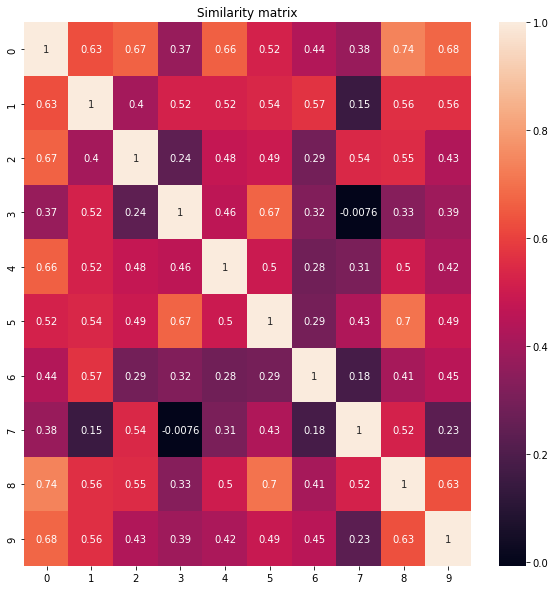

In [ ]:
# Plotting the similarity matrix "S"
plot_similarity_matrix(S)

In [ ]:
def Similarity_keywords_d2v(data=list(df["Keywords"]),end=100,step=10):
  """ 
  data : Series or list of texts or sentences
  """
  embed, keywords = [], []
  # Selection of two lists of keywords from the first 10 categories
  for i in range(0,end,step):
    keyword = re.sub("[^A-Za-z]"," ",data[i])
    keyword= keyword.strip()
    keywords.append( keyword)
    embed.append(modelDoc2Vec.infer_vector(data[i]))
  
  embed = np.array(embed)
  cos = cosine_similarity(embed,embed)
  return cos,keywords

Sk, keywords_d2v = Similarity_keywords_d2v()

In [ ]:
df_sim = pd.DataFrame(data=Sk, columns=keywords_d2v,index=keywords_d2v)
df_sim.head(2)

,violent bites aggressive attack public health predation hunt,organization reducing suffering inflicted on animals rights protection endangered species threatened,hardware system dangerous communication technologies computer,network function learning layer output,Roman ampheatre colosseum keystones museum,Elizabeth Campbell Tharawal Syndney metropolitan area british settlers camden,nonverbal communication behaviors express information,process acquire perceive comprehend language communicated use produce,act of the parliament emergency limit suspend public gathetings disease healthcare,infection fetuses predictions SARS MERS
violent bites aggressive attack public health predation hunt,1.000000,0.947711,0.938545,0.914934,0.907884,0.906551,0.936228,0.920448,0.944697,0.906760
organization reducing suffering inflicted on animals rights protection endangered species threatened,0.947711,1.000000,0.965176,0.902928,0.907927,0.886264,0.932876,0.938202,0.971710,0.936351


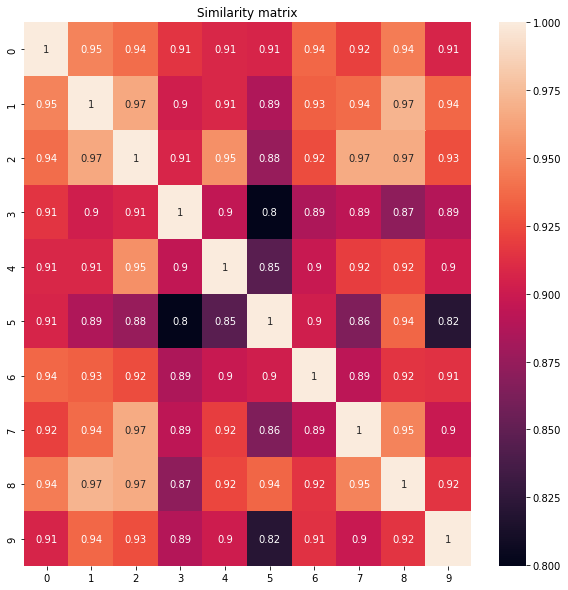

In [ ]:
# Plotting the similarity matrix "S"
plot_similarity_matrix(Sk)

 **Conclusion :**

Doc2Vec is not very accurate, he also made mistakes like **approaching** two contexts together when they are totally different, like talking about animals and artificial intelligence.

## Universal Sentence Encoder Embeddings

In [ ]:
import tensorflow_hub as hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def Similarity_use(data=list(df["Texts"]),end=100,step=10,n=25):
  sentences =  []
  # Selection of two texts from the first 10 categories
  for i in range(0,end,step):
    # Extract the first n words of each text
    L = data[i].split()
    sentences.append(" ".join(L[:n]))

  embeddings = use_model(sentences) 
  cosine_sim = cosine_similarity(embeddings, embeddings)
  
  return cosine_sim,sentences

Su, sentences_use = Similarity_use()

In [ ]:
df_sim = pd.DataFrame(data=Su, columns=sentences_use,index=sentences_use)
df_sim.head(1)

[]

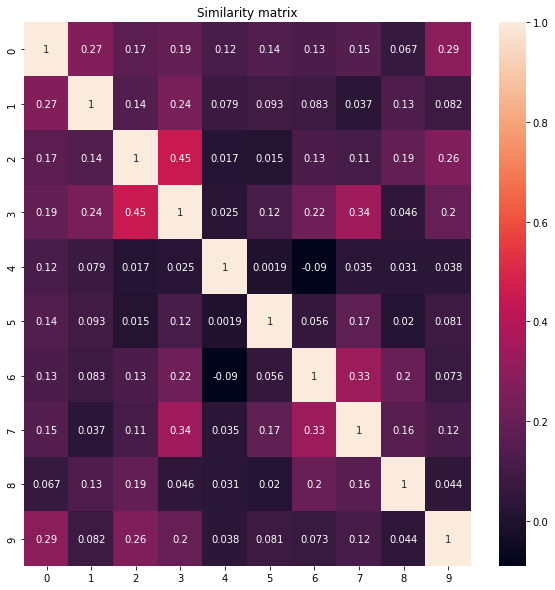

In [ ]:
# Plotting the similarity matrix 
plot_similarity_matrix(Su)

In [ ]:
def Similarity_keywords_use(data=list(df["Keywords"]),end=100,step=10):
  """ 
  data : Series or list of texts or sentences
  """
  keywords = []
  # Selection of two lists of keywords from the first 10 categories
  for i in range(0,end,step):
    keyword = re.sub("[^A-Za-z]"," ",data[i])
    keyword= keyword.strip()
    keywords.append( keyword) 
  
  embeddings = use_model(keywords) 
  cosine_sim = cosine_similarity(embeddings, embeddings)

  return cosine_sim,keywords

Sku, keywords_use = Similarity_keywords_use()

In [ ]:
df_sim = pd.DataFrame(data=Sku, columns=keywords_use,index=keywords_use)
df_sim.head(1)

[]

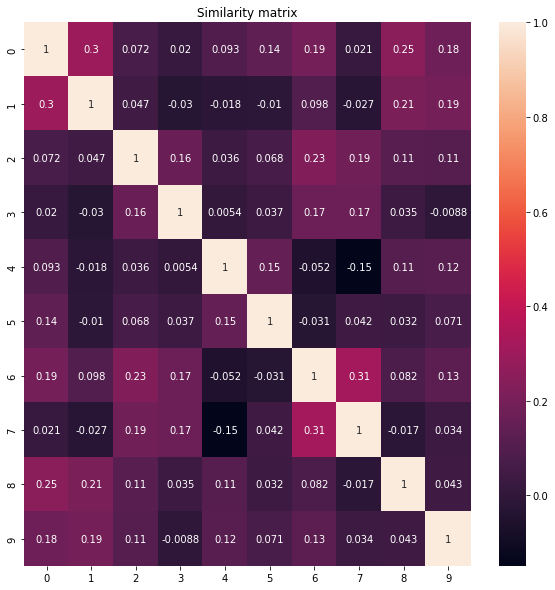

In [ ]:
# Plotting the similarity matrix 
plot_similarity_matrix(Sku)

## Sentence Bert model Embeddings

In [ ]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
def Similarity_bert(data=list(df["Texts"]),end=100,step=10,n=25):
  sentences =  []
  # Selection of two texts from the first 10 categories
  for i in range(0,end,step):
    # Extract the first n words of each text
    L = data[i].split()
    sentences.append(" ".join(L[:n]))

  embeddings = sbert_model.encode(sentences,convert_to_numpy=True) # Convert tensor type to numpy array
  cosine_sim = cosine_similarity(embeddings, embeddings)
  
  return cosine_sim,sentences

Sb, sentences_bert = Similarity_bert()

In [ ]:
df_sim = pd.DataFrame(data=Sb, columns=sentences_bert,index=sentences_bert)
df_sim.head(1)

,animal attack violent often fatal attack caused animal human one common bite bite wound caused result animal human attack attack cause human injury fatality worldwide,animal welfare institute awi american non profit charitable organization founded christine stevens goal reducing suffering inflicted animal human one oldest animal welfare organization u legislative,ai box hypothetical isolated computer hardware system possibly dangerous artificial intelligence ai kept constrained virtual prison solution ai control problem allowed directly manipulate event external,artificial neural network ann connectionist system computing system vaguely inspired biological neural network constitute animal brain system learn perform task considering example generally without programmed,amphitheatre capua roman amphitheatre city capua modern santa maria capua vetere second colosseum size probably model may first amphitheatre built roman location first famous gladiator,campbelltown city located outskirt metropolitan area sydney new south wale australia located greater western sydney kilometre mi south west sydney central business district campbelltown administrative,body language type nonverbal communication physical behavior opposed word used express convey information behavior includes facial expression body posture gesture eye movement touch use space,language acquisition process human acquire capacity perceive comprehend language word gain ability aware language understand well produce use word sentence communicate language acquisition involves structure,coronavirus act act parliament united kingdom grant government emergency power handle covid pandemic act allows government discretionary power limit suspend public gathering detain individual suspected,effect covid infection pregnancy completely known lack reliable data increased risk pregnant woman fetus far readily detectable prediction based similar infection sars mers suggest pregnant
animal attack violent often fatal attack caused animal human one common bite bite wound caused result animal human attack attack cause human injury fatality worldwide,1.0,0.345017,0.046534,0.15471,0.07912,0.088,0.20324,0.138563,0.251558,0.166452


[]

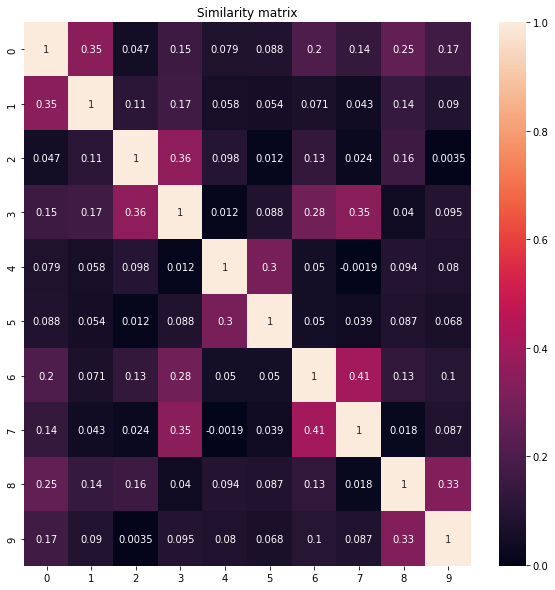

In [ ]:
# Plotting the similarity matrix "S"
plot_similarity_matrix(Sb)

In [ ]:
def Similarity_keywords_bert(data=list(df["Keywords"]),end=100,step=10):
  """ 
  data : Series or list of texts or sentences
  """
  keywords = []
  # Selection of two lists of keywords from the first 10 categories
  for i in range(0,end,step):
    keyword = re.sub("[^A-Za-z]"," ",data[i])
    keyword= keyword.strip()
    keywords.append( keyword) 
  
  embeddings = sbert_model.encode(keywords, convert_to_numpy=True) # convert tensor type to numpy array
  cosine_sim = cosine_similarity(embeddings, embeddings)


  return cosine_sim,keywords

Skb, keywords_bert = Similarity_keywords_bert()

In [ ]:
df_sim = pd.DataFrame(data=Skb, columns=keywords_bert,index=keywords_bert)
df_sim.head(1)

,violent bites aggressive attack public health predation hunt,organization reducing suffering inflicted on animals rights protection endangered species threatened,hardware system dangerous communication technologies computer,network function learning layer output,Roman ampheatre colosseum keystones museum,Elizabeth Campbell Tharawal Syndney metropolitan area british settlers camden,nonverbal communication behaviors express information,process acquire perceive comprehend language communicated use produce,act of the parliament emergency limit suspend public gathetings disease healthcare,infection fetuses predictions SARS MERS
violent bites aggressive attack public health predation hunt,1.0,0.484594,0.156321,-0.041221,-0.035853,0.032248,0.214555,0.067162,0.144616,0.126515


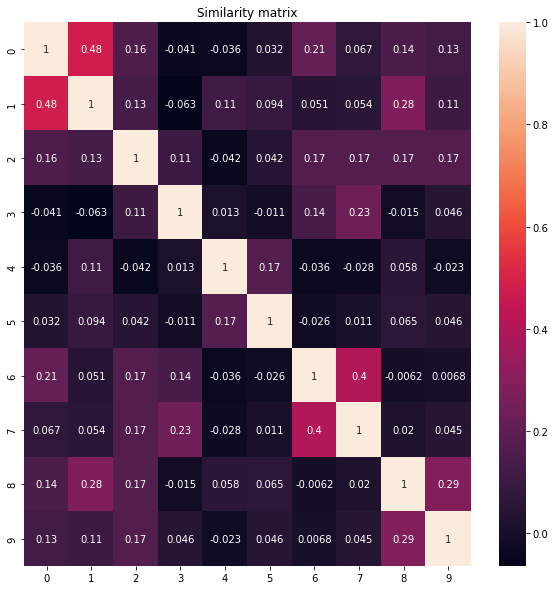

In [ ]:
# Plotting the similarity matrix "S"
plot_similarity_matrix(Skb)

## Conclusion:
Bert is the best model for our textual data to covert it into numeric data.

# KeyBert

As some texts are not associated with their keywords, we manage to extract them using the simplest method which is **`KeyBert`**.

In [ ]:
print(f'The number of texts without keywords is {len(df2["Keywords"][df2["Keywords"]=="Keywords"])}') 

In [ ]:
!pip install keybert
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT

In [ ]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')
kw_model_bert = KeyBERT(model=sbert_model) # the default model is distilbert, the used bert model showed better result

In [ ]:
doc = df["Texts"][4]
doc[:1000]

'animal law is combination of statutory and case law in which the nature legal social or biological of nonhuman animals is an important factor animal law encompasses companion animals wildlife animals used in entertainment and animals raised for food and research the emerging field of animal law is often analogized to the environmental law movement because animal law faces many of the same legal and strategic challenges that environmental law faced in seeking to establish more secure foothold in the united states and abroad animal law issues encompass broad spectrum of approaches from philosophical explorations of the rights of animals to pragmatic discussions about the rights of those who use animals who has standing to sue when an animal is harmed in way that violates the law and what constitutes legal cruelty animal law permeates and affects most traditional areas of the law including tort contract criminal and constitutional law examples of this intersection include animal custody 

In [ ]:
key = kw_model_bert.extract_keywords(doc[:1000], keyphrase_ngram_range=(1, 2), nr_candidates=15, top_n=10,stop_words='english')
key

[('animal law', 0.8594),
 ('rights animals', 0.7383),
 ('animal custody', 0.6862),
 ('sue animal', 0.6489),
 ('legal cruelty', 0.6371),
 ('environmental law', 0.5791),
 ('cruelty animal', 0.5683),
 ('case law', 0.5315),
 ('wildlife animals', 0.5282),
 ('animal harmed', 0.5248)]

In [ ]:
given_keywords = ['violent','bites','aggressive','attack','public health','predation','hunt'] # This is the given keywords(500 texts with their keywords)

In [ ]:
key_words = list(dict(key).keys())
key_words

['animal law',
 'rights animals',
 'animal custody',
 'sue animal',
 'legal cruelty',
 'environmental law',
 'cruelty animal',
 'case law',
 'wildlife animals',
 'animal harmed']

In [ ]:
# Pick the extracted keywords and mesure the similarity between the given keywords.
key_words = list(dict(key).keys()) # Same as [item[0] for item in key]
Embed = sbert_model.encode([" ".join(key_words)," ".join(given_keywords), doc],convert_to_numpy=True)
cos = cosine_similarity(Embed)

print(f'The similarity between the given keywords and the new ones is: {cos[0][1]}')
print(f'The similarity between the text and its the old keywords is : {cos[1][2]}')
print(f'The similarity between the text and its the new keywords is : {cos[0][2]}')

The similarity between the given keywords and the new ones is: 0.7749029397964478
The similarity between the text and its the old keywords is : 0.7558715343475342
The similarity between the text and its the new keywords is : 0.8302064538002014


In [ ]:
def keywords_extraction(old_df):
  """
  Input: the original dataFrame with the missing keywords
  Output: the new dataframe containing the missing keywords
  """
  
      # The most important part of each text, which is "the topic", is at the beginning of each text,
      # so we took the first 1000 items of each text, which gave a good result while testing it (similarity higher than 0.8).
      # "Note: This measure also aims to reduce resource consumption and execution time."

  df = old_df.copy()
  kw_model_bert = KeyBERT(model=sbert_model)

  for i in range(len(df["Keywords"])):
    if df["Keywords"][i]=="Keywords":
      key = kw_model_bert.extract_keywords(df["Texts"][i][:1000], keyphrase_ngram_range=(1, 2), nr_candidates=15, top_n=10)
      keywords = [item[0] for item in key]
      df["Keywords"][i]= str(keywords)

  return df


**Problem solved !**

In [ ]:
df_new = keywords_extraction(df) # It takes about 10 minutes to complete the execution
print(f'The number of texts without keywords is {len(df_new["Keywords"][df_new["Keywords"]=="Keywords"])}') 

In [ ]:
df_new.to_csv("gdrive/My Drive/Colab Notebooks/new_datafile.csv")

# Notebook Requirements

In [ ]:
import os 
!mkdir wiem

In [ ]:
!pip install pipreqs

In [ ]:
!pipreqs "/content/wiem/"

INFO: Successfully saved requirements file in /content/wiem/requirements.txt
